In [10]:
# pip install retina-face

In [11]:
# from retinaface import RetinaFace
# import os
# import cv2

In [12]:
# root="/content/drive/MyDrive"
# readdir=os.path.join(root,"raw_image")
# writedir=os.path.join(root,"persian_man")

In [13]:
# for i in range(1,42):
#   faces = RetinaFace.extract_faces(img_path =os.path.join(readdir,f"{i}.jpeg"), align = True)
#   for face in faces:
#     writepath=os.path.join(writedir,f"{i}.jpeg")
#     face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
#     cv2.imwrite(writepath,face)

In [14]:
!pip  install wandb

In [15]:
import tensorflow as tf
from tensorflow.keras import layers,optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import os
import datetime
import wandb
from wandb.keras import WandbCallback
import seaborn as sn

In [16]:
dataset_path = '/content/drive/MyDrive/Persian_Recognition'
width = height = 224
batch_size = 16

# Data Augmentation

In [17]:
data_generation = ImageDataGenerator(
    rescale = 1./255,
     horizontal_flip = True,
    validation_split= 0.2,
    fill_mode = 'nearst'
)

# Train_Data

In [18]:
train_data = data_generation.flow_from_directory(
    dataset_path,
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset= 'training'
)

Found 2346 images belonging to 2 classes.


In [19]:
val_data = data_generation.flow_from_directory(
    dataset_path,
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset= 'validation'
)

Found 586 images belonging to 2 classes.


In [20]:
print(np.bincount(train_data.labels))
print(np.bincount(val_data.labels))

[1694  652]
[423 163]


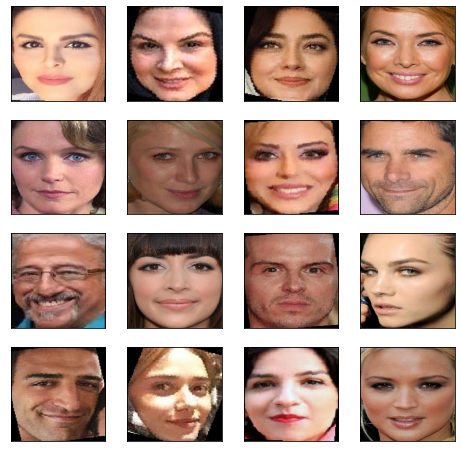

In [21]:
train_images = next(train_data)[0]
plt.figure(figsize = (8,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i] , cmap = plt.cm.binary)

In [22]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (width,height,3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
)

In [23]:
base_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f518317e150>>

In [24]:
for layer in base_model.layers[:-8]:
  layer.trainable = False

In [25]:
model=tf.keras.Sequential([
                           base_model,
                           layers.Dense(2,activation='softmax')
])

In [26]:
wandb.init(project="Persian_Recognition")

config = wandb.config
config.learning_rate = 0.001

wandb: Currently logged in as: cyber (use `wandb login --relogin` to force relogin)


In [27]:
model.compile(loss =losses.categorical_crossentropy,
              optimizer=optimizers.RMSprop(learning_rate=config.learning_rate),
                                        metrics = ['accuracy'])

In [28]:
model.fit( train_data,
          steps_per_epoch = train_data.samples/batch_size,
          validation_data = val_data,
          validation_steps = val_data.samples/batch_size,
          epochs = 20,
          class_weight = {0:1,1:3},
          callbacks = [WandbCallback()]
)

Epoch 1/20
146/146 [==============================] - 1808s 12s/step - loss: 4.8111 - accuracy: 0.8564 - val_loss: 9.9572 - val_accuracy: 0.7389


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
146/146 [==============================] - 31s 208ms/step - loss: 0.8940 - accuracy: 0.9066 - val_loss: 4.1337 - val_accuracy: 0.7611
Epoch 3/20
146/146 [==============================] - 30s 207ms/step - loss: 0.5225 - accuracy: 0.9301 - val_loss: 1.6032 - val_accuracy: 0.8208
Epoch 4/20
146/146 [==============================] - 35s 239ms/step - loss: 0.4065 - accuracy: 0.9382 - val_loss: 1.4728 - val_accuracy: 0.8089
Epoch 5/20
146/146 [==============================] - 31s 210ms/step - loss: 0.3000 - accuracy: 0.9561 - val_loss: 0.7353 - val_accuracy: 0.8754
Epoch 6/20
146/146 [==============================] - 31s 209ms/step - loss: 0.2999 - accuracy: 0.9548 - val_loss: 0.9384 - val_accuracy: 0.8618
Epoch 7/20
146/146 [==============================] - 30s 205ms/step - loss: 0.2488 - accuracy: 0.9565 - val_loss: 2.1414 - val_accuracy: 0.8038
Epoch 8/20
146/146 [==============================] - 30s 206ms/step - loss: 0.2163 - accuracy: 0.9719 - val_loss: 0.5420 - val_ac

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)
print('confusion matrix')
print(confusion_matrix(val_data.classes,y_pred))
target_names = list(val_data.class_indices.keys())
print('classification Report')
print(classification_report(val_data.classes,y_pred,target_names=target_names))

confusion matrix
[[314 109]
 [117  46]]
classification Report
              precision    recall  f1-score   support

     foreign       0.73      0.74      0.74       423
     persian       0.30      0.28      0.29       163

    accuracy                           0.61       586
   macro avg       0.51      0.51      0.51       586
weighted avg       0.61      0.61      0.61       586



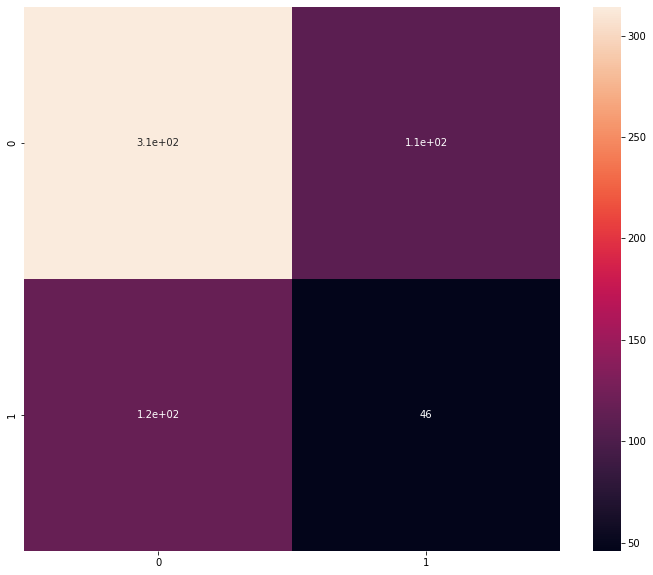

In [30]:
cm = confusion_matrix(val_data.classes,y_pred)
plt.figure(figsize=(12,10))
sn.heatmap(cm, annot=True)

In [32]:
model.save('persian_detection.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
!pip install pyTelegramBotAPI

     |████████████████████████████████| 101 kB 3.8 MB/s 
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.0.1-py3-none-any.whl size=79552 sha256=a1b9d944e67093660157dd5d525e6496798fab169c0989f0d0c192c760143b7a
  Stored in directory: /root/.cache/pip/wheels/2f/c4/5a/7440a72b0ee7aad2d7ba7b2b44a93953183a30b017f604bad3
Successfully built pyTelegramBotAPI


In [ ]:
import cv2
# from tensorflow.python.keras.models import load_model
import numpy as np
import telebot
from telebot import types

bot = telebot.TeleBot('1985737443:AAEbRJ8Nv3QrY-ACfYWBb0Hh4nL4_3u86NE')

@bot.message_handler(content_types=['photo'])
def photo(message):
    
    fileID = message.photo[-1].file_id
    print(fileID)
    
    file_info = bot.get_file(fileID)
    print(file_info)
    downloaded_file = bot.download_file(file_info.file_path)
    print(downloaded_file)
    with open(fileID, 'wb') as new_file:
        new_file.write(downloaded_file)

    

    image = cv2.imread(fileID)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255
    image = image.reshape(1, 224, 224, 3)

    pred = model.predict([image])

    result = np.argmax(pred)

    if result == 1:
        print('از برو بچه های خودمونه')
        bot.reply_to(message, 'از برو بچه های خودمونی')

    elif result == 0:
        print('اونور آبیه')
        bot.reply_to(message, 'اونور آبیه ')


@bot.message_handler(commands=['SendPic'])
def send_pic(message):
    bot.send_message(message.chat.id, 'tanx', reply_markup=buttons)


@bot.message_handler(commands=['start'])
def say_hello(message):
    bot.send_message(message.chat.id, f'خوش اومدین {message.from_user.first_name} ')


@bot.message_handler(func=lambda message: True)
def send_unknown(message):
    bot.reply_to(message, 'نامفهومه برام تا حالا ندیدمش!')


bot.polling()

AgACAgQAAxkBAAIBPGFOG-N3_Wef84c0s07aOsvPB3cqAAKUtTEbGCN4UoUVJgOQ194lAQADAgADbQADIQQ
{'file_id': 'AgACAgQAAxkBAAIBPGFOG-N3_Wef84c0s07aOsvPB3cqAAKUtTEbGCN4UoUVJgOQ194lAQADAgADbQADIQQ', 'file_unique_id': 'AQADlLUxGxgjeFJy', 'file_size': 5790, 'file_path': 'photos/file_34.jpg'}
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x12\x12\x15\x12\x12\x13\x15\x10\x15\x10\x10\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x15\x17\x16\x17\x16\x16\x15\x15\x15\x18\x1d( \x18\x1a%\x1b\x15\x16!1!%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x18+\x1d\x1d\x1d--+-+------+----+--------------------+------7+---7\xff\xc0\x00\x11\x08\x00\xa8\x01,\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x00\x07\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00?\x10\x00\x02\x01\x02\x03\x05\x05\x04\x08\x05\x03\x05\x01\x00\x00\x00\x01\x02\x00\x03\x11\x04\x05!\x06\x121AQaq\x81\x91\xa1\x13"2\xc1\x07\x14#B